In [30]:
library("tidyverse")
library("cowplot")
library("gridExtra")

In [37]:
run_id = "runs/binary/"
class_names = c("Tumor")
names(class_names) = paste0("class", 0:(length(class_names)-1))

## Load Data

In [38]:
out_dir = paste0(run_id,"output/")
log_dir = paste0(run_id,"logs/")

In [39]:
read_metrics <- function(fn) {
    read_csv(
        paste0(out_dir, fn), 
        show_col_types = FALSE
        ) %>%
        select(starts_with("class")) %>%
        pivot_longer(everything()) %>%
        mutate(name = recode(name, !!!class_names))
}

In [40]:
h_dist = read_metrics("HausdorffDistance_raw.csv") %>% 
    mutate(metric = "Hausdorff Distance")
s_dist = read_metrics("SurfaceDistance_raw.csv") %>% 
    mutate(metric = "Surface Distance")
dice = read_metrics("MeanDice_raw.csv") %>% 
    mutate(metric = "Dice Coeffcient")

## BoxPlots

In [42]:
boxplot <- function(data, ...) {
    ggplot(data, aes(x = name, y = value, fill = name)) + 
        geom_boxplot(outlier.alpha = 0) + 
        geom_point(
            position = position_jitter(width = 0.2, seed = 42), 
            size = 3, 
            alpha = 0.2
        ) +
        geom_point(
            position = position_jitter(width = 0.2, seed = 42), 
            shape = 1, 
            size = 3
        ) + 
        theme_cowplot() + 
        theme(
            legend.position = "none", 
            axis.title.x = element_blank(), 
            axis.text.x = element_text(size = 20),
            axis.title.y = element_text(size=24), 
            axis.text.y = element_text(size = 16)
            ) + 
        labs(...)
    }

    

In [43]:
boxplot_h_dist <-
    boxplot(h_dist, y = "Hausdorff Distance in mm") + 
        scale_fill_brewer(type="div", palette = 1)

In [44]:
boxplot_s_dist <-
    boxplot(s_dist, y = "Average Surface Distance in mm") + 
        scale_fill_brewer(type="div", palette = 1)

In [45]:
boxplot_dice <-
    boxplot(dice, y = "Dice Coefficient") + 
        scale_fill_brewer(type="div", palette = 1) + 
        ylim(0,1)

In [46]:
limits <- c(
    min(
        min(
            s_dist$value, 
            h_dist$value
        )
    ),
    max(
        max(
            s_dist$value, 
            h_dist$value
        )
    )
)

In [47]:
boxplot_multi <- function() {
    grid.arrange(
        grobs = list(
            boxplot_h_dist + 
                theme(axis.title.y = element_blank()) +
                labs(title = "Hausdorff \nDistance") +
                ylim(limits),          
            boxplot_s_dist + 
                theme(axis.title.y = element_blank()) +
                labs(title = "Average Surface \nDistance") +
                ylim(limits)
            , 
            boxplot_dice + 
                theme(axis.title.y = element_blank()) +
                labs(title = "Dice \nCoeffcient")
            ),
        nrow = 1
        )
    }

In [48]:
ggsave(filename = "boxplot_h_dist.pdf", plot = boxplot_h_dist, device = "pdf", width = 5, height = 8)
ggsave(filename = "boxplot_s_dist.pdf", plot = boxplot_s_dist, device = "pdf", width = 5, height = 8)
ggsave(filename = "boxplot_dice.pdf", plot = boxplot_dice, device = "pdf", width = 5, height = 8)

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


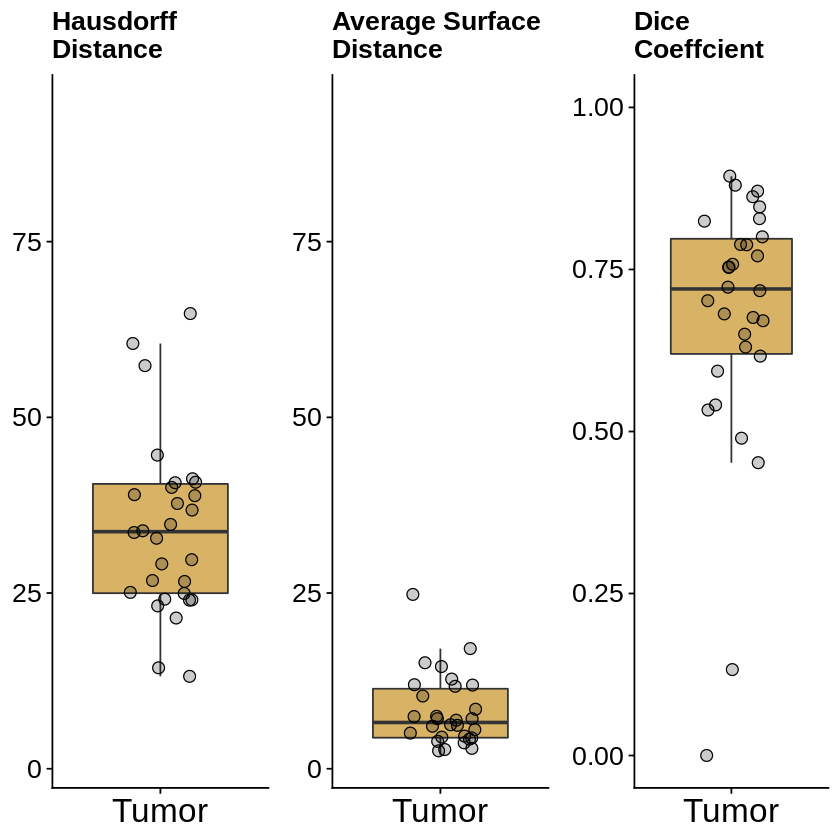

In [49]:
ggsave(filename = "boxplot_multi.pdf", plot = boxplot_multi(), device = "pdf", width = 10, height = 8)

## Tables

In [50]:
rbind(h_dist, s_dist, dice) %>%
    group_by(metric, name) %>%
    summarise(
        "Mean" = mean(value, na.rm = TRUE) %>% round(2), 
        "SD" = sd(value, na.rm = TRUE) %>% round(2), 
        "Median" = median(value, na.rm = TRUE) %>% round(2), 
        "IQR" = IQR(value, na.rm = TRUE) %>% round(2), 
        "Min" = min(value, na.rm = TRUE) %>% round(2), 
        "Max" = max(value, na.rm = TRUE) %>% round(2), 
        "5%" = quantile(value, prob = 0.05, na.rm = TRUE) %>% round(2),
        "25%" = quantile(value, prob = 0.25, na.rm = TRUE) %>% round(2),
        "50%" = quantile(value, prob = 0.5, na.rm = TRUE) %>% round(2),
        "75%" = quantile(value, prob = 0.75, na.rm = TRUE) %>% round(2),
        "95%" = quantile(value, prob = 0.95, na.rm = TRUE) %>% round(2),
        ) -> metric_table

`summarise()` has grouped output by 'metric'. You can override using the `.groups` argument.


In [51]:
print(knitr::kable(metric_table))



|metric             |name  |  Mean|    SD| Median|   IQR|   Min|   Max|    5%|   25%|   50%|   75%|   95%|
|:------------------|:-----|-----:|-----:|------:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|Dice Coeffcient    |Tumor |  0.67|  0.20|   0.72|  0.18|  0.00|  0.89|  0.28|  0.62|  0.72|  0.80|  0.88|
|Hausdorff Distance |Tumor | 35.94| 16.36|  33.73| 15.55| 13.15| 94.10| 17.55| 24.98| 33.73| 40.53| 62.85|
|Surface Distance   |Tumor |  7.97|  5.14|   6.58|  6.97|  1.88| 24.80|  2.63|  4.41|  6.58| 11.38| 16.19|


In [29]:
write_csv(metric_table, "metric_table.csv")